## Live Cell Analysis – Two channel spot tracking

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.ndimage as ndi

import pims
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature
import trackpy as tp
import pystackreg

### 1. Import and viewing

In [2]:
# TODO change to automatically accomodate more channels?

root = './data'

c1_name = '488-561' # Camera 1, reference
c2_name = '561-488' # Camera 2, to be aligned

In [3]:
def get_nd_files(root):
    files = sorted(glob.glob(f'{root}/*.nd'))
    files = [f.split('/')[-1] for f in files]
    files = [f.split('.')[0] for f in files]
    return files

In [4]:
files = get_nd_files(root)

@widgets.interact(file=widgets.Dropdown(options=files, description='File:'))
def f(file):
    global c_file, c1_file, c1_image, c2_file, c2_image
    c_file = file
    
    c1_file = glob.glob(f'{root}/{c_file}*{c1_name}*.stk')[0]
    c1_image = skimage.io.imread(c1_file)
    
    c2_file = glob.glob(f'{root}/{c_file}*{c2_name}*.stk')[0]
    c2_image = skimage.io.imread(c2_file)
    
    @widgets.interact(frame = widgets.IntSlider(min=1, max=c1_image.shape[0], description='Frame: '))
    def g(frame):
        fig, ax = plt.subplots(1, 2, figsize=(15,10))
        ax[0].set_title('Channel 1 ')
        ax[0].imshow(c1_image[frame-1])
        ax[1].set_title('Channel 2')
        ax[1].imshow(c2_image[frame-1])
        plt.show()

interactive(children=(Dropdown(description='File:', options=('Hela_pIM12_pIM52_sMH_Dox_1_4',), value='Hela_pIM…

### 2. Channel alignment

Description on which channels are taken and what is to be done

In [5]:
root_align = './align'

def get_align_image(root, name):
    file = get_nd_files(root)[0]
    img = glob.glob(f'{root}/{file}*{name}*.stk')[0]
    img = skimage.io.imread(img)
    img = img[0] if img.ndim==3 else img
    return img

c1_align = get_align_image(root_align, c1_name)
c2_align = get_align_image(root_align, c2_name)

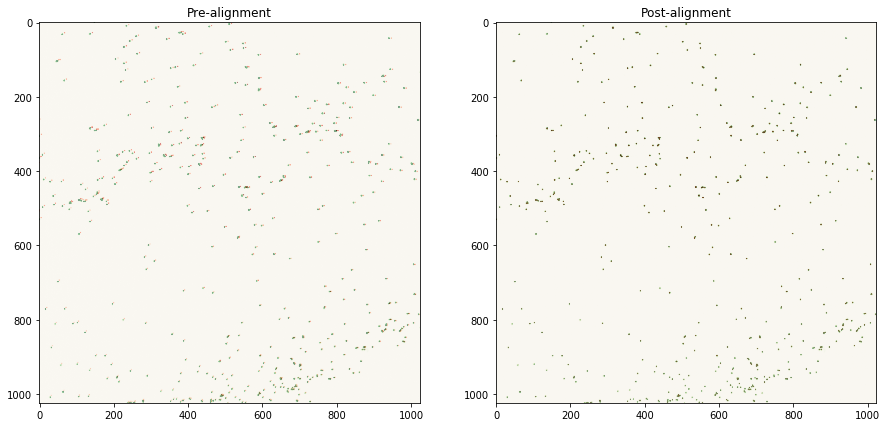

In [6]:
def align_matrix(img_ref, img_align):
    '''
    '''
    sr = pystackreg.StackReg(pystackreg.StackReg.SCALED_ROTATION)
    sr.register(img_ref, img_align)
    return sr

sr = align_matrix(c1_align, c2_align)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].set_title('Pre-alignment')
ax[0].imshow(c1_align, cmap='Greens')
ax[0].imshow(c2_align, cmap='Reds', alpha=0.5)
ax[1].set_title('Post-alignment')
ax[1].imshow(c1_align, cmap='Greens')
ax[1].imshow(sr.transform(c2_align), cmap='Reds', alpha=0.5)
plt.show()

In [7]:
def align_image_stack(img, sr):
    if img.ndim!=2:
        img_align = [align_image(i, sr) for i in img]
        return np.asarray(img_align)
    return sr.transform(img)

c2_image = np.array([align_image_stack(img, sr) for img in c2_image])

### 3. Segmentation

#### Minimum projection

To reduce the impact of high intensity spots we perform a minimum projection – this leaves us with a single image. As c1/c2 were only used as definitions for channel alignments, one must select which channel should be used for nuclear, which for cytoplasmic segmentation.

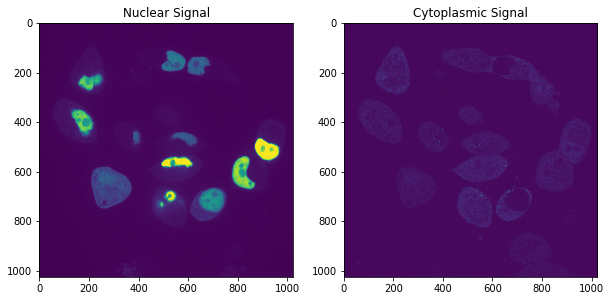

In [8]:
img_cytoplasm = c1_image
img_nucleus = c2_image

img_cytoplasm = np.min(img_cytoplasm, axis=0)
img_nucleus = np.min(img_nucleus, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Nuclear Signal')
ax[0].imshow(img_nucleus)
ax[1].set_title('Cytoplasmic Signal')
ax[1].imshow(img_cytoplasm)
plt.show()

#### Threshold by quantiles – nucleus

Smoothing helps to reduce unevenly shaped borders.

In [9]:
@widgets.interact(quantile = widgets.FloatSlider(value=0.9, min=0, max=1, step=0.05, description='Quantile: '))
def g(quantile):
    global img_thresh_nucleus
    
    img_smooth = skimage.filters.gaussian(img_nucleus, 2)
    img_quantile = np.quantile(img_smooth, quantile)
    img_thresh_nucleus = img_smooth > img_quantile

    plt.figure(figsize=(10, 5))
    plt.imshow(img_thresh_nucleus)
    plt.show()

interactive(children=(FloatSlider(value=0.9, description='Quantile: ', max=1.0, step=0.05), Output()), _dom_cl…

#### Find nuclear seeds

The following parameters can be altered:

- Sigma – Smoothing level. Increase it to reduce signal un-uniformities and make peak finding easier.
- Min_distance – Minimum distance between to peaks. Higher intensity peak will be used.
- Threshold_rel – Relative threshold in peak-proximity to be classified as peak.

In [10]:
@widgets.interact(
    sigma = widgets.IntSlider(value=10, min=0, max=20, description='Sigma: '),
    min_distance = widgets.IntSlider(value=50, min=1, max=500, description='Min. dist.: '),
    threshold_rel = widgets.FloatSlider(value=0.05, min=0, max=1, description='Rel. thresh.: ')
)
def g(sigma, min_distance, threshold_rel):
    global img_seeds
    
    img_smooth = skimage.filters.gaussian(img_nucleus, sigma)
    img_seeds = skimage.feature.peak_local_max(img_smooth,
                                               indices=False,
                                               min_distance=min_distance,
                                               threshold_rel=threshold_rel)
    img_seeds_dil = skimage.morphology.dilation(img_seeds, skimage.morphology.square(10))
    
    plt.figure(figsize=(15, 10))
    plt.imshow(img_nucleus)
    plt.jet()
    plt.imshow(img_seeds_dil, alpha=0.5, cmap='viridis')
    plt.title(len(np.unique(skimage.morphology.label(img_seeds))))
    plt.show()

interactive(children=(IntSlider(value=10, description='Sigma: ', max=20), IntSlider(value=50, description='Min…

####  Nuclear watershed

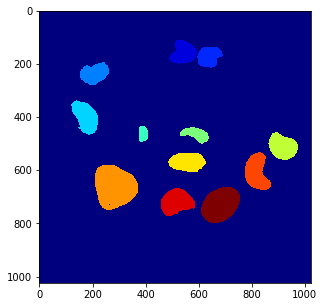

In [11]:
img_seeds = skimage.morphology.label(img_seeds)
img_seg_nucleus = skimage.segmentation.watershed(~img_thresh_nucleus, img_seeds, mask=img_thresh_nucleus)

plt.figure(figsize=(10, 5))
plt.imshow(img_seg_nucleus)
plt.show()

#### Threshold by quantiles – cytoplasm


In [12]:
@widgets.interact(quantile = widgets.FloatSlider(value=0.75, min=0, max=1, step=0.05, description='Quantile: '))
def g(quantile):
    global img_thresh_cytoplasm
    
    img_smooth = skimage.filters.gaussian(img_cytoplasm, 2)
    img_quantile = np.quantile(img_smooth, quantile)
    img_thresh_cytoplasm = img_smooth > img_quantile
    img_thresh_cytoplasm = ndi.binary_fill_holes(img_thresh_cytoplasm)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_thresh_cytoplasm)
    plt.show()

interactive(children=(FloatSlider(value=0.75, description='Quantile: ', max=1.0, step=0.05), Output()), _dom_c…

#### Watershed – cytoplasm

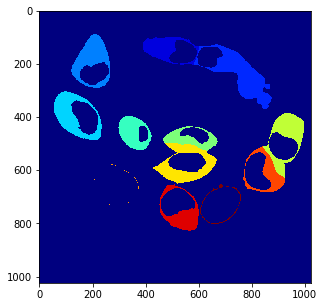

In [13]:
img_seg_cytoplasm = skimage.segmentation.watershed(~img_thresh_cytoplasm, img_seg_nucleus, mask=img_thresh_cytoplasm)
img_seg_cytoplasm = np.where(img_seg_nucleus, 0, img_seg_cytoplasm)

plt.figure(figsize=(10, 5))
plt.imshow(img_seg_cytoplasm)
plt.show()

#### Filter unwanted properties

In [14]:
# TODO?

### 4. Spot tracking

1. Assume all SunTag spots have mRNAs – necessity of unbiased acquisition. Tracking will include count per cell as well as average brightness.
2. Track mRNAs and measure SunTag proximity – i.e. having two tracks.


The resulting dataframe contains the following "measurements":
- frame – Image number in a sequence.
- x, y – Locations of the spot.
- mass – Total integrated brightness of the blob (bandpass filtered image).
- size – Radius of gyration of its gaussian-like profile. Measured 
- ecc – Eccentricity (0 is circular). Measured via sin and cos masks vs. mass.
- signal – Highest pixel value in preprocessed image.
- raw_mass – Total integrated brightness in raw_image (not preprocessed image).
- ep – Position uncertainty based on noise in environment.

#### Channel selection
Channel in which the spot detection should be performed.

In [23]:
frame = pims.Frame(c1_image)

#### Spot detection
Parameters:
- Image – frame in time series of images.
- Diameter – expected blob diameter (actual size still measured). When in doubt, round up.
- Minmass – the minimum integrated brightness.
- Percentile – spots must be above percentile. Default is 64.

In [24]:
@widgets.interact(img_slice = widgets.IntSlider(min=0, max=len(frame)-1, step=1, value=1, description='Frame: '),
          diameter = widgets.IntSlider(min=1, max=101, step=2, value=15, description='Diameter: '),
          minmass = widgets.IntSlider(min=0, max=100_000, step=1_000, value=50_000, description='Minmass: '),
          percentile = widgets.IntSlider(min=0, max=100, step=1, value=64, description='Percentile: '),
         )
def g(img_slice, diameter, minmass, percentile):
    global global_diameter, global_minmass, global_percentile
    global_diameter = diameter
    global_minmass = minmass
    global_percentile = percentile
    
    df_single = tp.locate(frame[img_slice], diameter=diameter, minmass=minmass, engine='numba')
    
    plt.figure(figsize=(15, 10))
    tp.annotate(df_single, frame[img_slice], imshow_style={'cmap':'viridis'})

interactive(children=(IntSlider(value=1, description='Frame: ', max=29), IntSlider(value=15, description='Diam…

In [25]:
# Run detection on all frames
df = tp.batch(frame, diameter=global_diameter, minmass=global_minmass, percentile=global_percentile, engine='numba')

Frame 29: 14 features


#### Linking

Parameters:
* Linking particles
    - Search range: maximum distance features can move between frames
    - Memory: maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle
    - Currently, no movement predictions are performed to increase execution speed. To change this, additional parameters can be found [here](http://soft-matter.github.io/trackpy/v0.4.2/generated/trackpy.link.html#trackpy.link)
    
    
* Filter trajectories
    - Threshold: minimum number of frames for spot to survive

Frame 29: 14 trajectories present.
Before: 92
After: 27


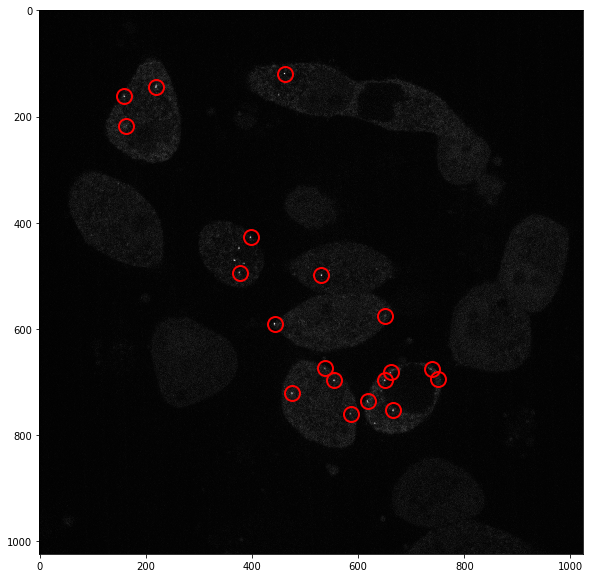

In [26]:
# Link particles
df = tp.link_df(df, search_range=5, memory=3)
print('Before:', df['particle'].nunique())

# Filter trajectories
df = tp.filter_stubs(df, threshold=5)
print('After:', df['particle'].nunique())

plt.figure(figsize=(15, 10))
tp.annotate(df[df['frame'] == 0], frame[0])
plt.show()

#### Drift subtraction
The drift is calculated to account for movements of all spots over frames, i.e. caused by cellular or microscopic stage movements. No parameters are necessary. 

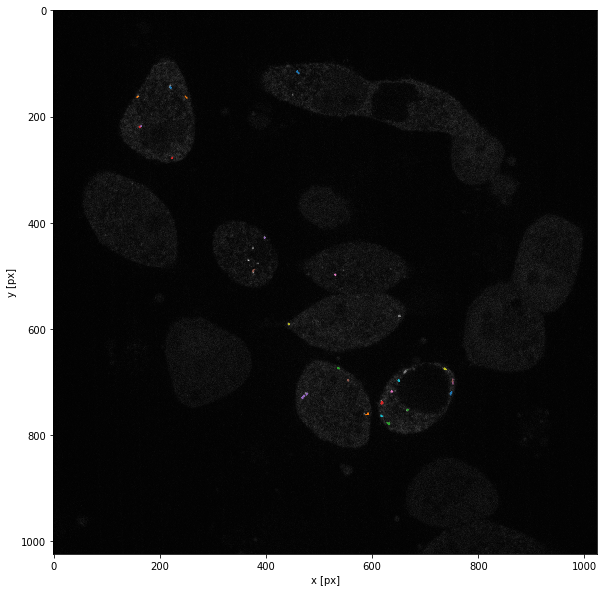

In [27]:
# Plot global drift
df_drift = tp.compute_drift(df)
# df_drift.plot()
# plt.show()

# Correct for drift
df = tp.subtract_drift(df.copy(), df_drift)

plt.figure(figsize=(15, 10))
ax = tp.plot_traj(df, superimpose=frame[0])
plt.show()

### 5. Measure other channels and cell number

As currently only one channel is tracked, one has to calculate the (potential) spot intensity in the second – untracked – channel. In addition, the tracks are assigned to their belonging cells. If a track is detected in the background it is sacrificed.

In [28]:
img_second = c2_image

In [29]:
# Cellular assignment
def assign_cell(img, y, x):
    return img[int(round(y)), int(round(x))]

df['cell'] = df.apply(lambda row: assign_cell(img_seg_cytoplasm, row['y'], row['x']), axis=1)
print('Before:', df['particle'].nunique())
df = df[df['cell']!=0] # Background
print('After:', df['particle'].nunique())

Before: 27
After: 11


In [30]:
# Intensity calculation
def assign_intensity(img, size, frame, y, x):
    return img[int(frame), int(round(y)), int(round(x))]

df['mass_second'] = df.apply(lambda row: assign_intensity(img_second, row['size'], row['frame'], row['y'], row['x']), axis=1)

In [31]:
df

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,cell,mass_second
frame,,,,,,,,,,,,
0,118.824619,462.017500,66105.695360,1.994902,0.044043,5795.699259,327012.0,0.022920,0,0,1,1631.053345
0,759.606696,585.806784,51867.291123,2.986642,0.099771,3190.756449,360623.0,0.019605,0,4,11,4269.654785
0,143.815196,220.111930,104733.028640,2.683302,0.198400,5359.844272,472601.0,0.013230,0,16,3,3338.326904
0,161.724270,159.580364,75172.990721,2.563202,0.047945,4955.426928,364894.0,0.019251,0,17,3,2695.665039
0,427.635534,397.894787,83070.740042,2.105649,0.037203,5628.433472,308237.0,0.025310,0,21,5,3977.210693
...,...,...,...,...,...,...,...,...,...,...,...,...
29,590.552794,443.137894,72110.890423,2.010681,0.069253,5275.417520,301334.0,0.034156,29,27,8,2298.412598
29,276.977068,222.027107,69772.271895,2.599844,0.020032,4615.180253,389770.0,0.022996,29,66,3,3937.749023
29,427.967496,397.543209,66869.741613,2.372099,0.122600,4915.841543,287922.0,0.036869,29,21,5,3037.073730


### 6. Output metrics

Different outputs for both types of measurements:
1. One row is one track
2. Number of frames colocalizing
3. Number of frames not colocalizing – maybe easier to do each frame and not sum up
4. Intensities in both channels

1. Assume all SunTag spots have mRNAs – necessity of unbiased acquisition. Tracking will include count per cell as well as average brightness.
2. Track mRNAs and measure SunTag proximity – i.e. having two tracks.

In [ ]:
columns = ['file', 'cell',
           'frame', 'y', 'x',
           'mass', 'size', 'ecc',
           'signal', 'raw_mass', 'ep',
           'mass_second']

df['file'] = c_file
df = df[columns]

In [ ]:
root_out = './out'

os.makedirs(root_out, exist_ok=True)
df.to_csv(f'./out/{c_file}.csv', index=False)